In [1]:
import torch
from transformers import SamModel, SamProcessor
from PIL import Image
import numpy as np
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


In [3]:


def predict_and_visualize(image_path, model, processor, device, box_prompt=None):
    # Load and preprocess the image
    image = Image.open(image_path)
    print(image.size)
    image = image.resize((256, 256), Image.LANCZOS)
    image_np = np.array(image)

    # Check if the image is 2D (grayscale)
    if len(image_np.shape) == 2:
        # Convert 2D grayscale to 3D RGB
        image_np = np.stack((image_np,) * 3, axis=-1)
    
    # Prepare the image for the model
    if box_prompt is not None:
        inputs = processor(image_np, input_boxes=[box_prompt], return_tensors="pt")
    else:
        inputs = processor(image_np, return_tensors="pt")  # predict without box prompt
    
    
    # Move inputs to the appropriate device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Generate masks
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=True)

    # Print the size of the predicted masks
    print(f"Predicted masks size: {outputs.pred_masks.shape}")
    
    # Apply sigmoid and convert to hard masks
    medsam_seg_probs = torch.sigmoid(outputs.pred_masks)
    medsam_seg_probs = medsam_seg_probs.cpu().numpy().squeeze()
    medsam_segs = (medsam_seg_probs > 0.5).astype(np.uint8)
    print(f"Segmentation masks shape: {medsam_segs.shape}")

    # Visualize the results
    num_masks = medsam_segs.shape[0]
    fig, axes = plt.subplots(1, num_masks + 1, figsize=(5 * (num_masks + 1), 5))
    
    # Ensure axes is always a list
    if num_masks == 0:
        axes = [axes]
    
    # Original image
    axes[0].imshow(image_np, cmap='gray' if len(image_np.shape) == 2 else None)
    axes[0].set_title("Original image")
    axes[0].axis('off')
    
    # Predicted masks
    for i in range(num_masks):
        axes[i+1].imshow(image_np, cmap='gray' if len(image_np.shape) == 2 else None)
        show_mask(medsam_segs[i], axes[i+1], random_color=True)
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')
    
   
    plt.tight_layout()
    plt.show()


Base model loaded!
Finetuned model loaded!
Segmentation without bbox prompt
(93, 193)
Predicted masks size: torch.Size([1, 1, 3, 256, 256])
Segmentation masks shape: (3, 256, 256)


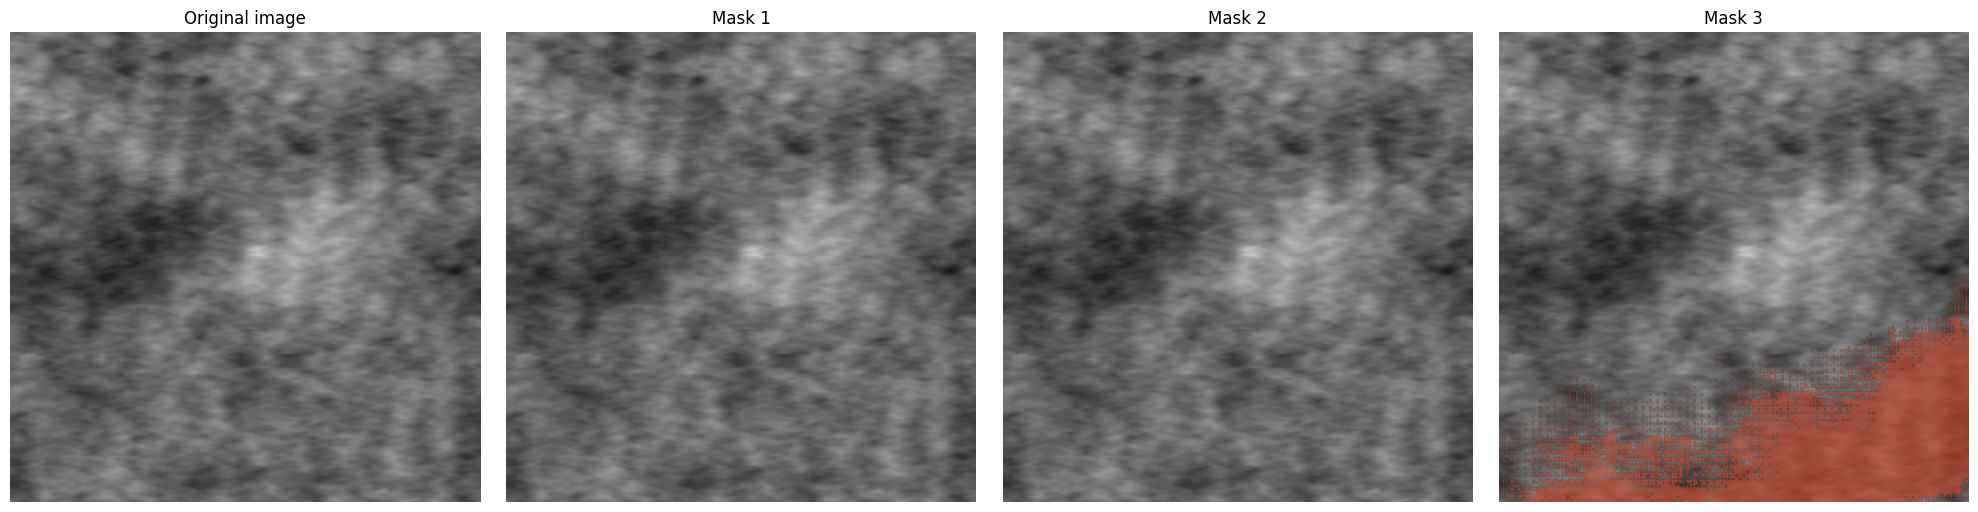

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the base model
model = SamModel.from_pretrained("wanglab/medsam-vit-base").to(device)
processor = SamProcessor.from_pretrained("wanglab/medsam-vit-base")
print('Base model loaded!')

# SAM
# processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
# model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

# model = SamModel.from_pretrained("facebook/sam-vit-huge")
# processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# Load the trained mask decoder
checkpoint = torch.load('best_mask_decoder_medsam_1000.pth', map_location=device)
model.mask_decoder.load_state_dict(checkpoint['mask_decoder_state_dict'])
print('Finetuned model loaded!')

# Set the model to evaluation mode
model.eval()

# Predict on a new image
#image_path = "/home/hpc/iwi5/iwi5171h/data_processing/calculated_dataset/stardist_dataset/closest_vertex_dataset/closest_vertex_high_degree_only_120/train/images/4571_od_129_7681_4_0_calculated_ref_51_lps_8_lbss_8_sr_n_50_cropped_5_0_0.tif"
image_path = "/home/hpc/iwi5/iwi5171h/data_processing/calculated_dataset/stardist_dataset/closest_vertex_dataset/closest_vertex_high_degree_only_120/train/images/5160_od_228_19122_6_0_Medium_calculated_ref_42_lps_8_lbss_8_sr_n_30_cropped_5_0_0.tif"
#image_path = '/home/hpc/iwi5/iwi5171h/medsam_file/MedSAM/assets/dog.tiff'

print("Segmentation without bbox prompt")
predict_and_visualize(image_path, model, processor, device)

In [6]:
def rescale_bbox(bboxes, original_size, target_size=(256, 256)):
    orig_w, orig_h = original_size
    target_w, target_h = target_size
    
    # Calculate scaling factors
    w_scale = target_w / orig_w
    h_scale = target_h / orig_h
    
    rescaled_bboxes = []
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        
        # Rescale coordinates
        new_x1 = int(x1 * w_scale)
        new_y1 = int(y1 * h_scale)
        new_x2 = int(x2 * w_scale)
        new_y2 = int(y2 * h_scale)
        
        rescaled_bboxes.append([new_x1, new_y1, new_x2, new_y2])
    
    return rescaled_bboxes

[[0, 0, 41, 19]]
Segmentation with box prompt
(93, 193)
Predicted masks size: torch.Size([1, 1, 3, 256, 256])
Segmentation masks shape: (3, 256, 256)


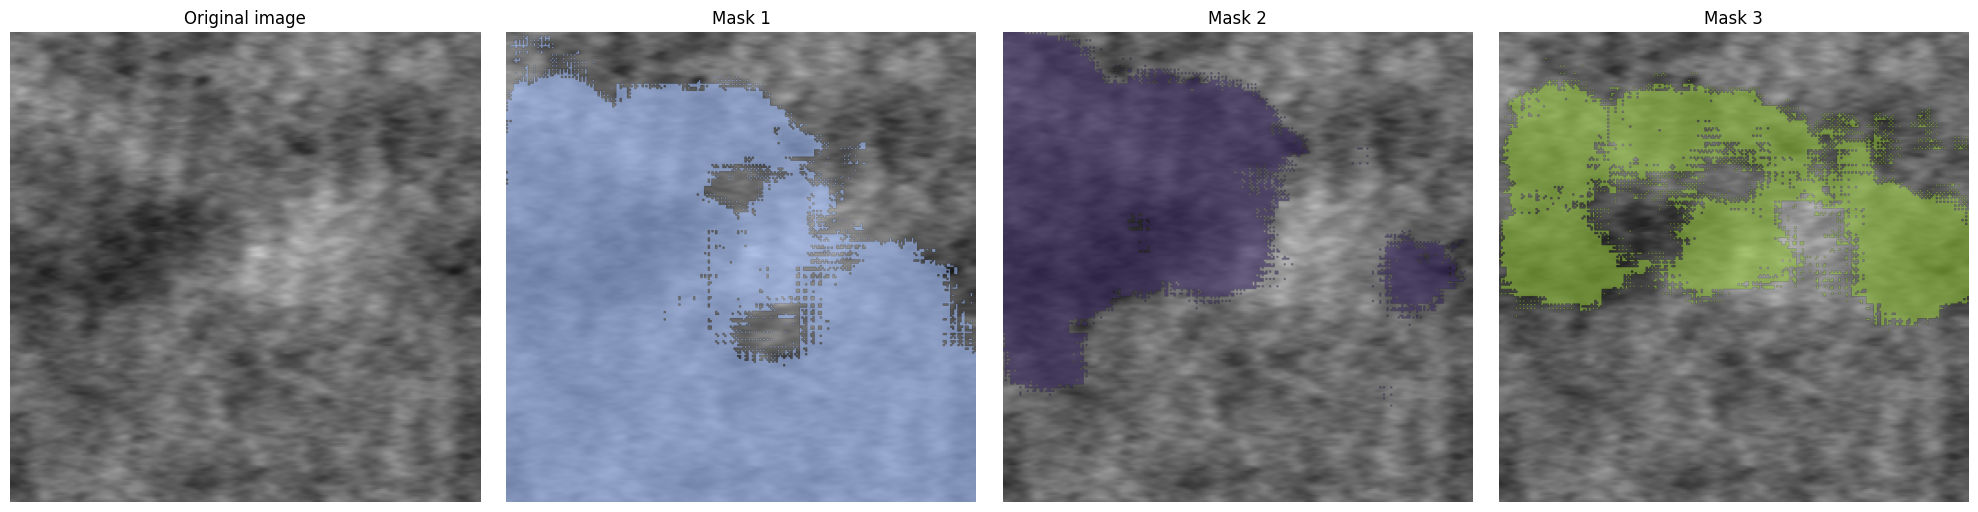

In [8]:
# Example box prompt [[x1, y1, x2, y2]] list of list

# dog image
#original_bbox = [[1115., 351., 1759., 1483.],
#                 [401., 534., 1082., 1472.],
#                 [1728., 561., 2271., 1446.]] # multi instance

# original_bbox = [[1115., 351., 1759., 1483.]] # single instance
# original_image_size = (2560, 1600) 

# photoreceptor
original_bbox = [[0., 0., 15., 15.]]
original_image_size = (93, 193)



# Rescale the bounding box
box_prompt = rescale_bbox(original_bbox, original_image_size)
print(box_prompt)

image_path = "/home/hpc/iwi5/iwi5171h/data_processing/calculated_dataset/stardist_dataset/closest_vertex_dataset/closest_vertex_high_degree_only_120/train/images/5160_od_228_19122_6_0_Medium_calculated_ref_42_lps_8_lbss_8_sr_n_30_cropped_5_0_0.tif"
#image_path = '/home/hpc/iwi5/iwi5171h/medsam_file/MedSAM/assets/dog.tiff'

print('Segmentation with box prompt')
predict_and_visualize(image_path, model, processor, device, box_prompt=box_prompt)